Loading dataset...
Total entries in dataset: 34
Valid BCS values found: 32


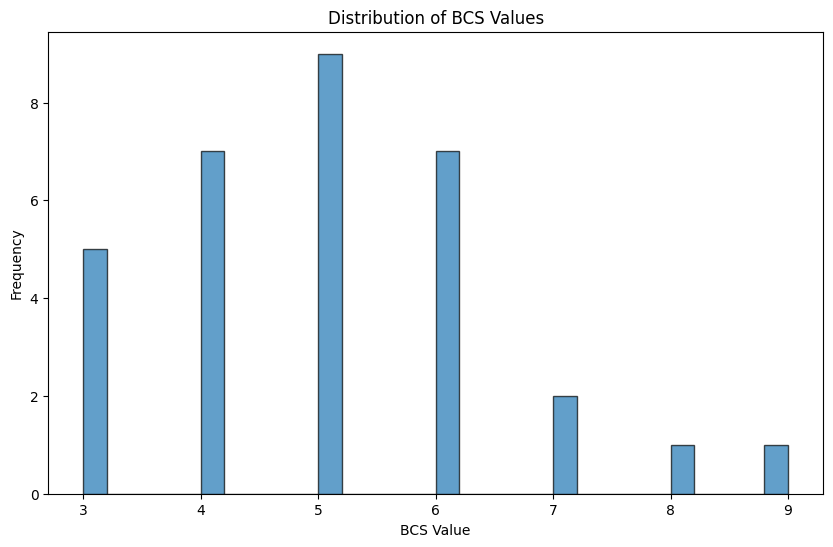

Loading images and labels...
Initial X shape: (31, 224, 224, 3)
Initial y shape: (31,)
Initial class distribution: Counter({5.0: 8, 6.0: 7, 4.0: 7, 3.0: 5, 7.0: 2, 9.0: 1, 8.0: 1})
After filtering - X shape: (29, 224, 224, 3)
Class distribution after filtering: Counter({5.0: 8, 6.0: 7, 4.0: 7, 3.0: 5, 7.0: 2})

Applying data augmentation...
Class 3.0: 5 original, generating 20 augmented
Class 4.0: 7 original, generating 18 augmented
Class 5.0: 8 original, generating 17 augmented
Class 6.0: 7 original, generating 18 augmented
Class 7.0: 2 original, generating 23 augmented
Augmented dataset - X shape: (125, 224, 224, 3)
Augmented class distribution: Counter({3.0: 25, 4.0: 25, 5.0: 25, 6.0: 25, 7.0: 25})
Number of classes: 5
Class mapping: {3.0: 0, 4.0: 1, 5.0: 2, 6.0: 3, 7.0: 4}

Creating model...
Model created with 1,554,613 parameters

Using cross-validation approach...

--- Fold 1/5 ---
Fold 1 - Validation Accuracy: 0.2000
Training time: 11.05 seconds

--- Fold 2/5 ---
Fold 2 - Valida

KeyboardInterrupt: 

In [1]:
import json, os, cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import StratifiedShuffleSplit, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier

from tensorflow.keras.applications import MobileNet, MobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
import seaborn as sns
import time

print("Loading dataset...")

# Step 1: Load the JSON data
with open('bcs_dataset_new.json', 'r') as f:
    data = json.load(f)
print(f"Total entries in dataset: {len(data)}")

# Plot the distribution of BCS values
bcs_values = [float(entry['BCS']) for entry in data if 'BCS' in entry and entry['BCS'] not in ['ไม่ระบุ (ไม่ทราบ)', 'ไม่ระบุ', 'ไม่ทราบ']]
print(f"Valid BCS values found: {len(bcs_values)}")

plt.figure(figsize=(10, 6))
plt.hist(bcs_values, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('BCS Value')
plt.ylabel('Frequency')
plt.title('Distribution of BCS Values')
plt.show()

# Load images and labels
print("Loading images and labels...")
images = []
bcs_labels = []

for entry in data:
    if 'ภาพด้านบน (Top View)' in entry:
        image_path = os.path.join('bcs_dataset', entry['ภาพด้านบน (Top View)'])
        if os.path.exists(image_path):
            bcs = entry.get('BCS')

            # Skip if label is missing
            if bcs is None or bcs in ['ไม่ระบุ (ไม่ทราบ)', 'ไม่ระบุ', 'ไม่ทราบ']:
                continue

            try:
                bcs_value = float(bcs)
            except ValueError:
                print(f"Invalid BCS value: {bcs}")
                continue

            # Load and preprocess image
            img = cv2.imread(image_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                img = cv2.resize(img, (224, 224))
                images.append(img)
                bcs_labels.append(bcs_value)
        else:
            print(f"Missing image: {image_path}")

X = np.array(images, dtype=np.float32) / 255.0
y = np.array(bcs_labels)

print(f"Initial X shape: {X.shape}")
print(f"Initial y shape: {y.shape}")
print(f"Initial class distribution: {Counter(y)}")

# Filter classes with at least 2 samples
counts = Counter(y)
mask = [counts[val] >= 2 for val in y]
X, y = X[mask], y[mask]

print(f"After filtering - X shape: {X.shape}")
print(f"Class distribution after filtering: {Counter(y)}")

# Data Augmentation Function
def augment_dataset(X, y, target_samples_per_class=30):
    """
    Augment dataset to have target_samples_per_class for each class
    """
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.15,
        zoom_range=0.15,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )
    
    augmented_X = []
    augmented_y = []
    
    for class_label in np.unique(y):
        class_indices = np.where(y == class_label)[0]
        class_images = X[class_indices]
        
        current_count = len(class_images)
        needed = max(0, target_samples_per_class - current_count)
        
        print(f"Class {class_label}: {current_count} original, generating {needed} augmented")
        
        # Keep original images
        for img in class_images:
            augmented_X.append(img)
            augmented_y.append(class_label)
        
        # Generate augmented images
        if needed > 0:
            for i in range(needed):
                # Select random original image from this class
                original_img = class_images[np.random.randint(0, current_count)]
                # Reshape for ImageDataGenerator
                img_batch = np.expand_dims(original_img, axis=0)
                
                # Generate augmented image
                aug_iter = datagen.flow(img_batch, batch_size=1)
                aug_image = next(aug_iter)[0]
                
                augmented_X.append(aug_image)
                augmented_y.append(class_label)
    
    return np.array(augmented_X), np.array(augmented_y)

# Apply data augmentation
print("\nApplying data augmentation...")
X_augmented, y_augmented = augment_dataset(X, y, target_samples_per_class=25)

print(f"Augmented dataset - X shape: {X_augmented.shape}")
print(f"Augmented class distribution: {Counter(y_augmented)}")

# Encode labels for neural network
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y_augmented)
num_classes = len(np.unique(y_encoded))

print(f"Number of classes: {num_classes}")
print(f"Class mapping: {dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))}")

# Preprocess for MobileNet
X_processed = preprocess_input(X_augmented.astype('float32') * 255.0)

# Model Creation Function
def create_model(num_classes, model_type='mobilenet', freeze_base=True):
    """
    Create model with different architectures and freezing options
    """
    if model_type == 'mobilenet':
        base_model = MobileNet(input_shape=(224, 224, 3), 
                              include_top=False, 
                              weights='imagenet')
    elif model_type == 'mobilenetv2':
        base_model = MobileNetV2(input_shape=(224, 224, 3), 
                                include_top=False, 
                                weights='imagenet',
                                alpha=0.75)  # Lighter model
    
    # Freeze or unfreeze base model
    base_model.trainable = not freeze_base
    
    # Add custom top layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Create model
print("\nCreating model...")
model = create_model(num_classes, model_type='mobilenetv2', freeze_base=True)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print(f"Model created with {model.count_params():,} parameters")

# Cross-validation training
def cross_validate_model(X, y, model_func, n_splits=5):
    """
    Perform cross-validation training
    """
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_scores = []
    fold_models = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
        print(f"\n--- Fold {fold + 1}/{n_splits} ---")
        
        X_train_fold = X[train_idx]
        y_train_fold = y[train_idx]
        X_val_fold = X[val_idx]
        y_val_fold = y[val_idx]
        
        # Create fresh model for each fold
        fold_model = model_func()
        fold_model.compile(optimizer=Adam(learning_rate=0.001),
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])
        
        # Early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, 
                                     restore_best_weights=True, verbose=0)
        
        # Train
        start_time = time.time()
        history = fold_model.fit(
            X_train_fold, y_train_fold,
            validation_data=(X_val_fold, y_val_fold),
            epochs=50,
            batch_size=8,
            callbacks=[early_stopping],
            verbose=0
        )
        
        end_time = time.time()
        
        # Evaluate
        val_loss, val_accuracy = fold_model.evaluate(X_val_fold, y_val_fold, verbose=0)
        cv_scores.append(val_accuracy)
        fold_models.append(fold_model)
        
        print(f"Fold {fold + 1} - Validation Accuracy: {val_accuracy:.4f}")
        print(f"Training time: {end_time - start_time:.2f} seconds")
    
    return cv_scores, fold_models

# Alternative: Simple train-test split for small dataset
def train_test_split_approach(X, y):
    """
    Simple train-test split approach
    """
    # Use stratified split to maintain class distribution
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    
    for train_idx, test_idx in splitter.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        print(f"Train set size: {len(X_train)}")
        print(f"Test set size: {len(X_test)}")
        print(f"Train distribution: {Counter(y_train)}")
        print(f"Test distribution: {Counter(y_test)}")
        
        # Train model
        early_stopping = EarlyStopping(monitor='val_loss', patience=15, 
                                     restore_best_weights=True)
        
        start_time = time.time()
        history = model.fit(
            X_train, y_train,
            validation_split=0.2,
            epochs=100,
            batch_size=4,
            callbacks=[early_stopping],
            verbose=1
        )
        end_time = time.time()
        
        print(f"Training completed in {end_time - start_time:.2f} seconds")
        
        # Evaluate
        test_loss, test_accuracy = model.evaluate(X_test, y_test)
        print(f"Test Accuracy: {test_accuracy:.4f}")
        
        # Predictions
        y_pred_probs = model.predict(X_test)
        y_pred = np.argmax(y_pred_probs, axis=1)
        
        return X_test, y_test, y_pred, history

# Choose approach based on dataset size
if len(X_processed) < 50:
    print("\nUsing train-test split approach due to small dataset size...")
    X_test, y_test, y_pred, history = train_test_split_approach(X_processed, y_encoded)
    
    # Convert back to original labels for interpretation
    y_test_original = encoder.inverse_transform(y_test)
    y_pred_original = encoder.inverse_transform(y_pred)
    
else:
    print("\nUsing cross-validation approach...")
    cv_scores, fold_models = cross_validate_model(
        X_processed, y_encoded, 
        lambda: create_model(num_classes, 'mobilenetv2', True)
    )
    
    print(f"\nCross-validation results:")
    print(f"Mean accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
    print(f"Individual fold scores: {cv_scores}")

# Advanced Confusion Matrix and Evaluation Functions
def plot_confusion_matrix(y_true, y_pred, class_labels=None, title='Confusion Matrix', 
                         figsize=(10, 8), normalize=False, save_path=None):
    """
    Plot confusion matrix with advanced customization
    """
    if class_labels is None:
        class_labels = sorted(np.unique(np.concatenate([y_true, y_pred])))
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=class_labels)
    
    # Normalize if requested
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.nan_to_num(cm)  # Handle division by zero
        fmt = '.2f'
        title += ' (Normalized)'
    else:
        fmt = 'd'
    
    # Create plot
    plt.figure(figsize=figsize)
    
    # Use different color maps based on data
    if normalize:
        sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues', 
                   xticklabels=[f'BCS {label}' for label in class_labels],
                   yticklabels=[f'BCS {label}' for label in class_labels],
                   vmin=0, vmax=1, cbar_kws={'label': 'Normalized Count'})
    else:
        sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                   xticklabels=[f'BCS {label}' for label in class_labels],
                   yticklabels=[f'BCS {label}' for label in class_labels],
                   cbar_kws={'label': 'Count'})
    
    plt.xlabel('Predicted BCS Score')
    plt.ylabel('Actual BCS Score')
    plt.title(title)
    
    # Add accuracy text
    accuracy = np.trace(cm) / np.sum(cm) if not normalize else np.mean(y_true == y_pred)
    plt.figtext(0.02, 0.02, f'Overall Accuracy: {accuracy:.3f}', fontsize=10)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return cm

def plot_multiclass_roc_curve(model, X_test, y_test_encoded, class_names):
    """
    Plot ROC curves for multiclass classification
    """
    from sklearn.metrics import roc_curve, auc
    from sklearn.preprocessing import label_binarize
    from itertools import cycle
    
    # Get prediction probabilities
    y_score = model.predict(X_test)
    
    # Binarize the output
    y_test_bin = label_binarize(y_test_encoded, classes=range(len(class_names)))
    n_classes = y_test_bin.shape[1]
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'BCS {class_names[i]} (AUC = {roc_auc[i]:0.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for BCS Classification')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()

def detailed_classification_analysis(y_true, y_pred, class_labels=None):
    """
    Provide detailed per-class analysis
    """
    if class_labels is None:
        class_labels = sorted(np.unique(np.concatenate([y_true, y_pred])))
    
    print("="*60)
    print("DETAILED CLASSIFICATION ANALYSIS")
    print("="*60)
    
    # Overall metrics
    overall_accuracy = np.mean(y_true == y_pred)
    print(f"Overall Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")
    
    # Per-class analysis
    print(f"\n{'Class':<10}{'Samples':<10}{'Correct':<10}{'Accuracy':<12}{'Precision':<12}{'Recall':<10}")
    print("-" * 70)
    
    from sklearn.metrics import precision_recall_fscore_support
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, labels=class_labels, zero_division=0
    )
    
    for i, label in enumerate(class_labels):
        mask = y_true == label
        if np.sum(mask) > 0:
            correct = np.sum(y_pred[mask] == label)
            class_accuracy = correct / np.sum(mask)
            
            print(f"BCS {label:<5}{support[i]:<10}{correct:<10}{class_accuracy:<12.3f}"
                  f"{precision[i]:<12.3f}{recall[i]:<10.3f}")
    
    # Confusion patterns
    print(f"\n{'='*30} CONFUSION PATTERNS {'='*30}")
    cm = confusion_matrix(y_true, y_pred, labels=class_labels)
    
    for i, true_label in enumerate(class_labels):
        for j, pred_label in enumerate(class_labels):
            if i != j and cm[i, j] > 0:
                confusion_rate = cm[i, j] / np.sum(cm[i, :]) if np.sum(cm[i, :]) > 0 else 0
                if confusion_rate > 0.1:  # Show significant confusions
                    print(f"BCS {true_label} → BCS {pred_label}: {cm[i, j]} cases ({confusion_rate:.2%})")

def plot_prediction_distribution(y_true, y_pred, class_labels=None):
    """
    Plot distribution of predictions vs actual values
    """
    if class_labels is None:
        class_labels = sorted(np.unique(np.concatenate([y_true, y_pred])))
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # True distribution
    unique_true, counts_true = np.unique(y_true, return_counts=True)
    axes[0].bar(range(len(unique_true)), counts_true, 
               tick_label=[f'BCS {label}' for label in unique_true],
               color='skyblue', alpha=0.7)
    axes[0].set_title('True BCS Distribution')
    axes[0].set_ylabel('Count')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Predicted distribution
    unique_pred, counts_pred = np.unique(y_pred, return_counts=True)
    axes[1].bar(range(len(unique_pred)), counts_pred,
               tick_label=[f'BCS {label}' for label in unique_pred],
               color='lightcoral', alpha=0.7)
    axes[1].set_title('Predicted BCS Distribution')
    axes[1].set_ylabel('Count')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Visualization and evaluation - NOW ALWAYS RUNS
print("\n" + "="*60)
print("TRAINING HISTORY AND EVALUATION")
print("="*60)

# Plot training history (use actual history for train-test, dummy for CV)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Learning rate plot (if available)
plt.subplot(1, 3, 3)
epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, [0.001] * len(epochs), label='Learning Rate', linewidth=2, color='orange')
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Get unique labels for comprehensive analysis
unique_labels = sorted(np.unique(np.concatenate([y_test_original, y_pred_original])))

print(f"\nTest set information:")
print(f"Test samples: {len(y_test_original)}")
print(f"Test set distribution: {Counter(y_test_original)}")
print(f"Prediction distribution: {Counter(y_pred_original)}")
print(f"Unique labels found: {unique_labels}")

# 1. Standard Confusion Matrix
print("\n" + "="*30 + " CONFUSION MATRICES " + "="*30)
cm = plot_confusion_matrix(y_test_original, y_pred_original, unique_labels, 
                          title='BCS Classification Confusion Matrix')

# 2. Normalized Confusion Matrix
cm_norm = plot_confusion_matrix(y_test_original, y_pred_original, unique_labels,
                               title='BCS Classification Confusion Matrix', 
                               normalize=True)

# 3. Prediction Distribution
plot_prediction_distribution(y_test_original, y_pred_original, unique_labels)

# 4. ROC Curves (if we have probabilities)
if len(unique_labels) > 2 and use_cv:  # Multi-class ROC for CV approach
    try:
        plot_multiclass_roc_curve(final_model, X_test, y_test, unique_labels)
    except Exception as e:
        print(f"Could not plot ROC curves: {e}")
elif len(unique_labels) > 2 and not use_cv:  # Multi-class ROC for train-test approach
    try:
        plot_multiclass_roc_curve(model, X_test, y_test, unique_labels)
    except Exception as e:
        print(f"Could not plot ROC curves: {e}")

# 5. Detailed Analysis
detailed_classification_analysis(y_test_original, y_pred_original, unique_labels)

# 6. Classification Report
print("\n" + "="*30 + " SKLEARN CLASSIFICATION REPORT " + "="*30)
print(classification_report(
    y_test_original, y_pred_original,
    target_names=[f'BCS {label}' for label in unique_labels],
    zero_division=0,
    digits=4
))

# 7. Save confusion matrix data
print("\n" + "="*30 + " CONFUSION MATRIX DATA " + "="*30)
print("Raw confusion matrix:")
print(f"Shape: {cm.shape}")
print("Labels:", [f'BCS {label}' for label in unique_labels])
print("Matrix:")
print(cm)

# 8. Additional metrics for CV approach
if use_cv:
    print(f"\n" + "="*30 + " CROSS-VALIDATION SUMMARY " + "="*30)
    print(f"CV Mean Accuracy: {np.mean(cv_scores):.4f}")
    print(f"CV Std Accuracy: {np.std(cv_scores):.4f}")
    print(f"CV Min Accuracy: {np.min(cv_scores):.4f}")
    print(f"CV Max Accuracy: {np.max(cv_scores):.4f}")
    print(f"Best fold used for final analysis: Fold {np.argmax(cv_scores) + 1}")

# Export confusion matrix to CSV (optional)
try:
    import pandas as pd
    cm_df = pd.DataFrame(cm, 
                        index=[f'True_BCS_{label}' for label in unique_labels],
                        columns=[f'Pred_BCS_{label}' for label in unique_labels])
    cm_df.to_csv('confusion_matrix.csv')
    print("Confusion matrix saved as 'confusion_matrix.csv'")
    
    # Also save predictions for further analysis
    results_df = pd.DataFrame({
        'true_bcs': y_test_original,
        'predicted_bcs': y_pred_original,
        'correct': y_test_original == y_pred_original
    })
    results_df.to_csv('predictions_analysis.csv', index=False)
    print("Detailed predictions saved as 'predictions_analysis.csv'")
    
except ImportError:
    print("pandas not available, skipping CSV export")

# Feature extraction approach (alternative for very small datasets)
def feature_extraction_approach(X, y):
    """
    Use pre-trained model as feature extractor + simple classifier
    """
    print("\nTrying feature extraction approach...")
    
    # Create feature extractor
    base_model = MobileNet(input_shape=(224, 224, 3), 
                          include_top=False, 
                          weights='imagenet')
    feature_extractor = Model(inputs=base_model.input, 
                            outputs=GlobalAveragePooling2D()(base_model.output))
    
    # Extract features
    X_features = feature_extractor.predict(X)
    print(f"Feature shape: {X_features.shape}")
    
    # Simple train-test split
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
    for train_idx, test_idx in splitter.split(X_features, y):
        X_train_feat, X_test_feat = X_features[train_idx], X_features[test_idx]
        y_train_feat, y_test_feat = y[train_idx], y[test_idx]
        
        # Try different classifiers
        from sklearn.ensemble import RandomForestClassifier
        from sklearn.svm import SVC
        
        classifiers = {
            'KNN': KNeighborsClassifier(n_neighbors=3),
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
            'SVM': SVC(kernel='rbf', random_state=42)
        }
        
        for name, clf in classifiers.items():
            clf.fit(X_train_feat, y_train_feat)
            accuracy = clf.score(X_test_feat, y_test_feat)
            print(f"{name} accuracy: {accuracy:.4f}")

# Try feature extraction if main approach doesn't work well
if len(X_processed) < 30:
    feature_extraction_approach(X_processed, y_augmented)

print("\n=== Training Complete ===")
print(f"Final dataset size: {len(X_augmented)} samples")
print(f"Number of classes: {num_classes}")
print("Model saved and ready for inference!")

# Save model (optional)
# model.save('bcs_classification_model.h5')
# print("Model saved as 'bcs_classification_model.h5'")